 - Dados 1: https://dados.gov.br/dados/conjuntos-dados/medicoes-de-campos-eletromagneticos1 (campos eletromagnéticos)
 - Dados 2: https://www.telecocare.com.br/mapaerbs/ (mapa de erbs do brasil - Anatel)

In [1]:
import pandas as pd
import numpy as np
import math as Math
import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Pré processamento

Dataframe (df) com as medições dos campos eletromagnéticos

In [2]:
#dataframe com as medições dos campos elétricos
df = pd.read_csv('Medicoes_de_Campos_Eletromagneticos_2016-2020.csv', sep = ';', low_memory = False)

df['Latitude'] = df['Latitude'].str.replace(',','.')
df['Longitude'] = df['Longitude'].str.replace(',','.')
df['Valor Medio'] = df['Valor Medio'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace('%','')

df = df.astype({'Latitude':'float','Longitude':'float','Valor Medio':'float','% do Limite':'float'})

df.head(3)

,Responsável,Nome Responsável,Data da Medicao,Hora da Medicao,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,-30.046873,-51.206071,Porto Alegre,RS,0.27,0.01,N/I,NaN
1,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,-30.046873,-51.206071,Porto Alegre,RS,0.40,0.02,N/I,NaN
2,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,-27.597640,-48.548560,Florianópolis,SC,0.48,0.03,N/I,NaN


Dataframe com as localizações de todas as ERBs pelo Brasil

In [3]:
#dataframe com as localizações de antenas (ERBs) de acordo com o número da estação
dferb = pd.read_csv('erbs.csv', sep=';', encoding = 'utf-8')

dferb.rename(columns={'NumEstacao':'Número Estação', 'Latitude':'ErbLat', 'Longitude':'ErbLong'}, inplace = True)
dferb = dferb.astype({'Número Estação':'str','ErbLat':'float','ErbLong':'float', 'Bairro':'str','IBGE':'str'})

dferb.head(3)

,Número Estação,Operadora,SiglaUf,MUN,Bairro,LOGRADOURO,ErbLat,ErbLong,IBGE,Tecs
0,1058,TIM,AL,Flexeiras,nan,RODOVIA BR 101 NORTE 0 MORRO CORTE NOVO,-9.241111,-35.779472,2702801,2G 3G 4G
1,2119,TIM,AL,Maceió,nan,"RUA SAO FRANCISCO DE ASSIS,1000,JATIUCA",-9.654881,-35.712517,2704302,2G 3G 4G
2,3549,Vivo,RS,Vacaria,nan,"Av. Julio de Castilhos, ,925,Centro",-28.505547,-50.935831,4322509,2G 3G 4G


Join de ambos os dataframes: medições (df) e ERBs (dferb)

In [4]:
mdf = pd.merge(df, dferb, how = 'inner', on = 'Número Estação')

mdf.drop(['Responsável','SiglaUf','MUN','Bairro','LOGRADOURO','IBGE','Operadora da Estação','SiglaUf'], axis = 1, inplace = True)

#criação da coluna Time: combina colunas Data e Hora e passa ao formato DateTime
mdf['Time'] = pd.to_datetime(df['Data da Medicao'] + ' ' +df['Hora da Medicao'], format='%d/%m/%Y %H:%M:%S')
mdf.drop(['Data da Medicao', 'Hora da Medicao'], axis = 1, inplace = True)

mdf.info()
mdf.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151527 entries, 0 to 151526
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Nome Responsável  151527 non-null  object        
 1   Tipo de Medicao   151527 non-null  object        
 2   Latitude          151527 non-null  float64       
 3   Longitude         151527 non-null  float64       
 4   Municipio         151527 non-null  object        
 5   UF                151527 non-null  object        
 6   Valor Medio       151527 non-null  float64       
 7   % do Limite       151527 non-null  float64       
 8   Número Estação    151527 non-null  object        
 9   Operadora         151527 non-null  object        
 10  ErbLat            151527 non-null  float64       
 11  ErbLong           151527 non-null  float64       
 12  Tecs              151527 non-null  object        
 13  Time              151527 non-null  datetime64[ns]
dtypes: d

,Nome Responsável,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora,ErbLat,ErbLong,Tecs,Time
0,Agência Nacional de Telecomunicações,Fixas,-10.503258,-39.008258,Euclides da Cunha,BA,0.35,0.02,695504177,TIM,-10.503278,-39.008528,2G 3G,2016-01-01
1,Agência Nacional de Telecomunicações,Fixas,-10.502900,-39.008733,Euclides da Cunha,BA,0.37,0.02,695504177,TIM,-10.503278,-39.008528,2G 3G,2016-01-01
2,Agência Nacional de Telecomunicações,Fixas,-10.503967,-39.008739,Euclides da Cunha,BA,0.37,0.02,695504177,TIM,-10.503278,-39.008528,2G 3G,2016-01-01


### Feature Engineering

Criação da feature distância (entre as ERBs e seus pontos de medição). Utilização da Fórmula de Haversine para determinar a distância entre dois pontos ao longo de uma superfície esférica, dadas suas latitudes e longitudes.
    
https://en.wikipedia.org/wiki/Haversine_formula

In [5]:
#Fórmula de Haversine: distância entre 2 pontos em superfície esférica, dadas latitude/longitude
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R = 6371;
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1) 
    a =  Math.sin(dLat/2) * Math.sin(dLat/2) + Math.cos(deg2rad(lat1)) * Math.cos(deg2rad(lat2)) * Math.sin(dLon/2) * Math.sin(dLon/2)
    c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a))
    d = R * c
    return d

#conversão de graus para radianos
def deg2rad(deg):
    return deg * (Math.pi/180)

#criação da feature distância
mdf['Distancia'] = np.vectorize(getDistanceFromLatLonInKm)(mdf['ErbLat'], mdf['ErbLong'], mdf['Latitude'], mdf['Longitude'])

#fornecer a distância em metros
mdf['Distancia'] *= 1000

#apenas uma casa decimal para as distâncias
mdf['Distancia'] = round(mdf['Distancia'],1)

mdf.head(3)

,Nome Responsável,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora,ErbLat,ErbLong,Tecs,Time,Distancia
0,Agência Nacional de Telecomunicações,Fixas,-10.503258,-39.008258,Euclides da Cunha,BA,0.35,0.02,695504177,TIM,-10.503278,-39.008528,2G 3G,2016-01-01,29.6
1,Agência Nacional de Telecomunicações,Fixas,-10.502900,-39.008733,Euclides da Cunha,BA,0.37,0.02,695504177,TIM,-10.503278,-39.008528,2G 3G,2016-01-01,47.6
2,Agência Nacional de Telecomunicações,Fixas,-10.503967,-39.008739,Euclides da Cunha,BA,0.37,0.02,695504177,TIM,-10.503278,-39.008528,2G 3G,2016-01-01,80.0


### Análise Exploratória de Dados (EDA)
    A seguir:
    -Observe que, após combinados os dataframes, há 8 empresas responsáveis pela realização das atividades de medição dos campos eletromagnéticos das ERBs. Entre elas estão a ANATEL e outras.
    -Foram realizados 2 tipos de medição: Fixas ou Faixa Larga.
    -Foram feitas medições em 4086 municípios distintos, abrangendo 27 estados da federação.

In [6]:
#informações básicas sobre o dataset
print(f'Total de empresas responsáveis: {len(mdf["Nome Responsável"].unique())}')
print(f'Tipos de medição: {len(mdf["Tipo de Medicao"].unique())}')
print(f'Total de Municípios Distintos: {len(mdf["Municipio"].unique())}')
print(f'Total de Unidades da Federação: {len(mdf["UF"].unique())}')
print('\nPercentual de estações por operadora:')

#mostra as operadoras envolvidas nas medições
mdf['Operadora'].value_counts(normalize = True)

Total de empresas responsáveis: 8
Tipos de medição: 2
Total de Municípios Distintos: 4086
Total de Unidades da Federação: 27

Percentual de estações por operadora:


TIM          0.418117
Claro        0.351957
Vivo         0.206636
Algar        0.015779
Sercomtel    0.007510
Name: Operadora, dtype: float64

In [7]:
#datafrane filtrado somente para a região de Anápolis
mdf_anapolis = mdf[(mdf['UF'] == 'GO') & (mdf['Municipio'] == 'Anápolis')]

#Latitudes e Longitudes mínimas e máximas encontradas para locais de medição na cidade de Anápolis
latmin_anapolis = min(mdf_anapolis['Latitude'])
latmax_anapolis = max(mdf_anapolis['Latitude'])
longmin_anapolis = min(mdf_anapolis['Longitude'])
longmax_anapolis = max(mdf_anapolis['Longitude'])

#Latitudes e Longitudes mínimas e máximas encontradas para locais de medição em todo o Brasil
latmin_bra = min(mdf['Latitude'])
latmax_bra = max(mdf['Latitude'])
longmin_bra = min(mdf['Longitude'])
longmax_bra = max(mdf['Longitude'])

#mostra as coordenadas máximas e mínimas para as medições ao longo do Brasil e ao longo da cidade de Anápolis
print('\nLatitudes/Longitudes mínimas e máximas encontradas para as medições efetuadas:\n')
print(f'Brasil\nlatmin: {latmin_bra}\nlatmax: {latmax_bra}\nlongmin: {longmin_bra}\nlongmax: {longmax_bra}\n')
print(f'Anápolis\nlatmin: {latmin_anapolis}\nlatmax: {latmax_anapolis}\nlongmin: {longmin_anapolis}\nlongmax: {longmax_anapolis}\n')


Latitudes/Longitudes mínimas e máximas encontradas para as medições efetuadas:

Brasil
latmin: -33.69033
latmax: 3.84241
longmin: -72.90744
longmax: -32.40124

Anápolis
latmin: -16.41152
latmax: -16.25403
longmin: -48.99911
longmax: -48.7867



Extração das características geográficas dos mapas pelas coordenadas
    
Bounding boxes para: Brasil e Anápolis

Extraem-se as coordenadas máximas e mínimas das medições e, com base nelas, extrai-se um mapa que abranja todas essas coordenadas, através do seguinte website:
    
https://www.openstreetmap.org/
    
Os pontos em azul revelam as latitudes e as longitudes de onde foram realizadas as medições.

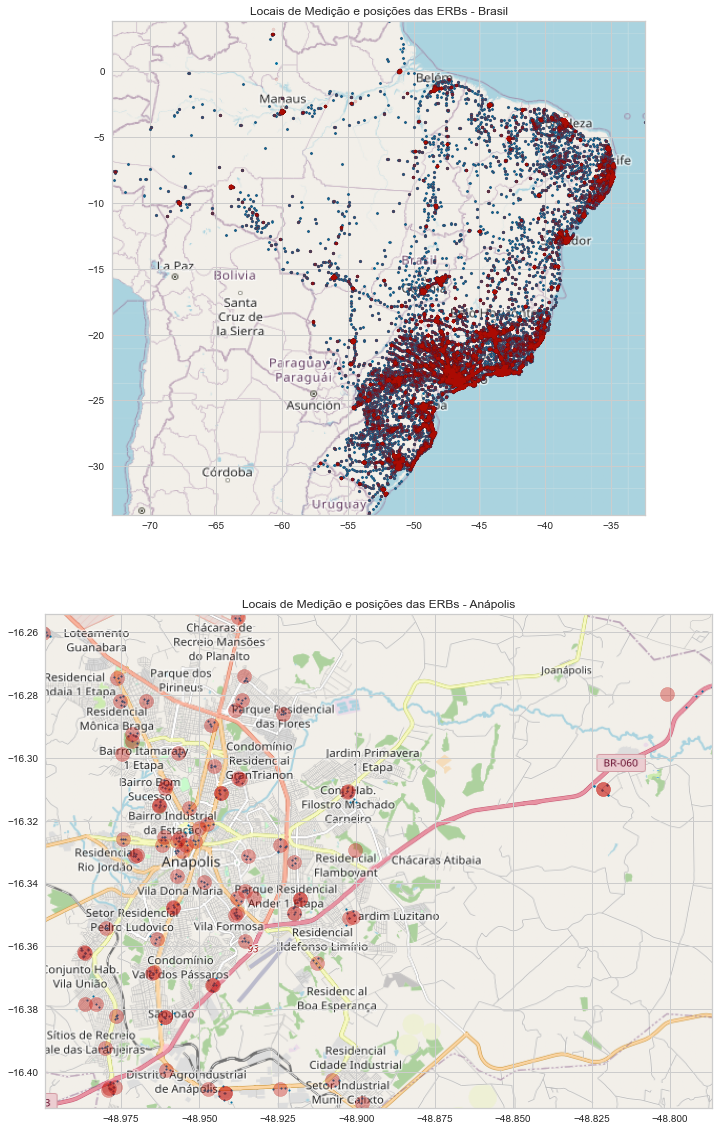

In [8]:
#bounding boxes para o Brasil e Anápolis (finalidade: delimitar a extração de mapa)
BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
BBox_anapolis = ((longmin_anapolis, longmax_anapolis, latmin_anapolis, latmax_anapolis))

brasil = plt.imread('brasil.png')
anapolis = plt.imread('anapolis.png')

#plotagem do locais das medições (azul) e das posições das ERBs (vermelho)
fig, axs = plt.subplots(2,1,figsize = (18,20))

#plotagem para o Brasil inteiro
axs[0].scatter(mdf.Longitude, mdf.Latitude, zorder=1, alpha= 1, c='b', s=3)
axs[0].scatter(mdf.ErbLong, mdf.ErbLat, zorder=1, alpha= 0.03, c='r', s=10)
axs[0].set_title('Locais de Medição e posições das ERBs - Brasil')
axs[0].set_xlim(BBox_bra[0],BBox_bra[1])
axs[0].set_ylim(BBox_bra[2],BBox_bra[3])
axs[0].imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')

#plotagem para a cidade de Anápolis
axs[1].scatter(mdf_anapolis.Longitude, mdf_anapolis.Latitude, zorder=1, alpha= 1, c='b', s=3)
axs[1].scatter(mdf_anapolis.ErbLong, mdf_anapolis.ErbLat, zorder=1, alpha= 0.1, c='r', s=200)
axs[1].set_title('Locais de Medição e posições das ERBs - Anápolis')
axs[1].set_xlim(BBox_anapolis[0],BBox_anapolis[1])
axs[1].set_ylim(BBox_anapolis[2],BBox_anapolis[3])
axs[1].imshow(anapolis, zorder=0, extent = BBox_anapolis, aspect= 'equal')

In [9]:
print(f'Número total de estações: {len(mdf["Número Estação"].unique())}')
print(f'Número aproximado de medições por estação: {len(mdf) / len(mdf["Número Estação"].unique())}')

Número total de estações: 31590
Número aproximado de medições por estação: 4.79667616334283


### Algoritmos não-supervisionados
    
Elbow method para identificar clusterização ideal para o algoritmo KMeans. Observe que k = 5 fornece uma aparente clusterização ideal. Para esse caso, observe como o algoritmo parece diferenciar naturalmente entre regiões norte, nordeste, centro-oeste, sudeste e sul.

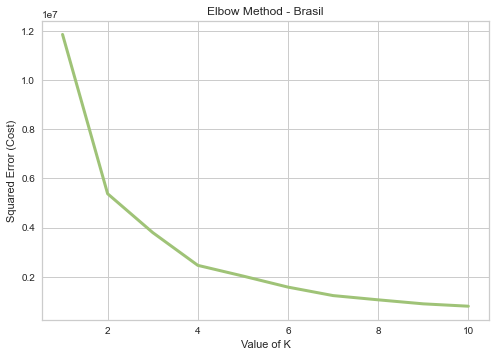

In [10]:
def elbow_method(X,title):
    cost =[]
    for i in range(1, 11):
        KM = KMeans(n_clusters = i, max_iter = 500, n_init=10)
        KM.fit(X)

        # calculates squared error
        # for the clustered points
        cost.append(KM.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
    plt.title(title)
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot
    
elbow_method(mdf[['Latitude','Longitude']], 'Elbow Method - Brasil')

#### KMeans

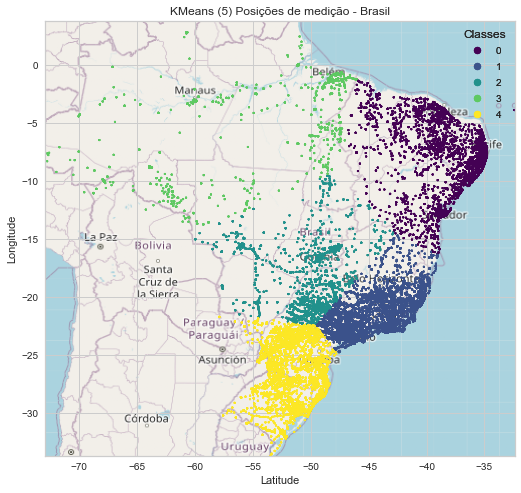

In [11]:
def plot_kmeans(k,df,xcol,ycol):
    X = df[[xcol,ycol]]
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    predictions = kmeans.predict(X)
    
    BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
    brasil = plt.imread('brasil.png')
    
    fig, axs = plt.subplots(1,1,figsize = (16,8))
    scatter = axs.scatter(df.Longitude, df.Latitude, zorder=1, alpha= 1, c=predictions, s=3, cmap = 'viridis')
    axs.set_title(f'KMeans ({k}) Posições de medição - Brasil')
    axs.set_xlim(BBox_bra[0],BBox_bra[1])
    axs.set_ylim(BBox_bra[2],BBox_bra[3])
    legend1 = axs.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    axs.add_artist(legend1)
    axs.set_xlabel(xcol)
    axs.set_ylabel(ycol)
    axs.imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')
    
plot_kmeans(5, mdf, 'Latitude', 'Longitude')

### Análise Exploratória de Dados

Relação entre o valor do campo elétrico (em V/m) e as distâncias (em metros) dos pontos de medição e suas respectivas ERBs relacionadas.
    
Observe que o gráfico obtido é bastante semelhante ao gráfico fornecido pela análise do Prof. Ph.D Marco Antonio Brasil Terada em "Análise da Intensidade de Campo Elétrico de Estações Rádio-Base":
    
TERADA, Marco Antonio Brasil. Análise da Intensidade de Campo Elétrico de Estações Rádio-Base. Inatel, 2008. Disponível em: https://www.inatel.br/revista/busca/144-5-analise-da-intensidade-de-campo-s504918-1/file>.

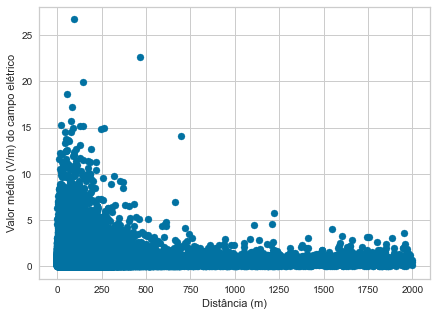

In [12]:
#plota o gráfico do valor do campo elétrico medido em função da distância entre o ponto de medição e a ERB correspondente
dmax = 2000

fig, axs = plt.subplots(1,1, figsize=(7,5))
axs.scatter(mdf[mdf['Distancia'] < dmax]['Distancia'], mdf[mdf['Distancia'] < dmax]['Valor Medio'])
axs.set_xlabel('Distância (m)')
axs.set_ylabel('Valor médio (V/m) do campo elétrico');

<img align="left" src="grafico_artigo_campos_erbs.png">

#### Silhouette Analysis:
    
Mede o quão um elemento é similar ao cluster a que pertence (coesão) em relação a outros clusters (separação). O silhouette score varia de [-1,1], sendo que valores mais próximos de 1 indicam que o elemento está muito bem identificado ao próprio cluster a que pertence em relação aos demais clusters. 
    
A média do silhouette score é representada pela linha pontilhada vermelha. Um número de objetos com silhouette score elevado significa que a clusterização é apropriada. Caso a maior parte dos pontos possua silhouette score baixo ou negativo, significa pode haver clusters em demasia ou em falta.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

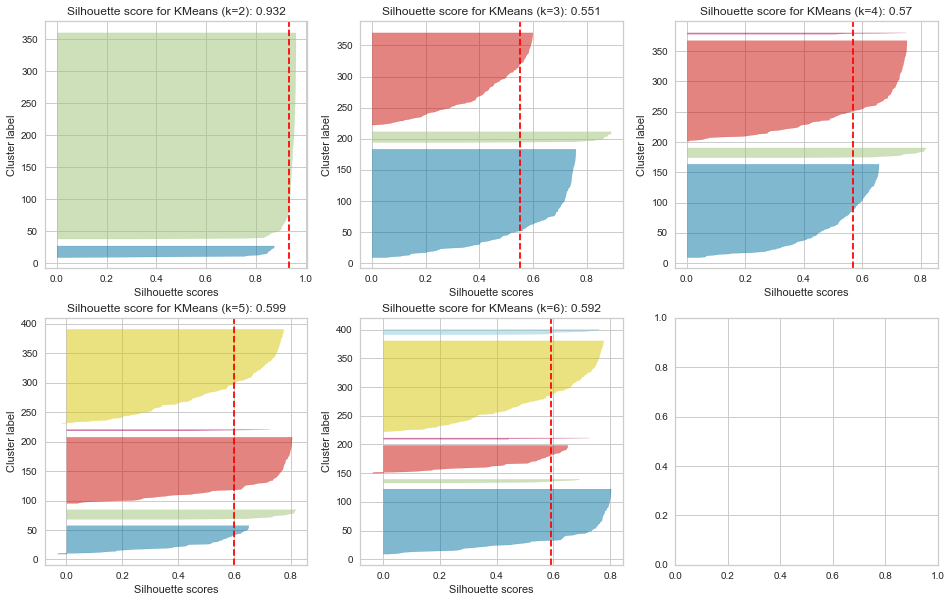

In [13]:
def plot_silhouette(X, kmin, kmax):
    fig, axs = plt.subplots(2,3,figsize=(16,10))
    for i,k in enumerate(range(kmin,kmax)):
        kmeans = KMeans(n_clusters = k, n_init=10)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax = axs[i//3,i%3], )
        visualizer.fit(X)  
        score = silhouette_score(X, kmeans.labels_, metric='euclidean')
        axs[i//3,i%3].set_title(f'Silhouette score for KMeans (k={k}): {round(score,3)}')
        axs[i//3,i%3].set_xlabel('Silhouette scores')
        axs[i//3,i%3].set_ylabel('Cluster label')
        
plot_silhouette(mdf_anapolis[['Distancia','Valor Medio']], 2, 7)

### Algoritmos não-supervisionados
    
#### DBSCAN
    
Observe que o algoritmo agrega boa parte dos dados até a distância de aproximadamente 750m. Possivelmente essa informação corrobore com as regiões de campo próximo (Fresnel) e regiões de campo distante (Fraunhofer) para antenas.

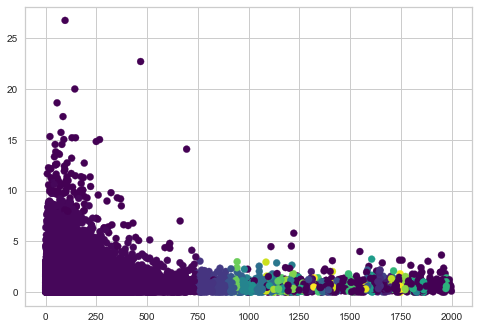

In [14]:
#filtra as medições cujas distâncias sejam menores que 2000m (padrão de alcance de ERBs)
ff = mdf[mdf['Distancia'] <= 2000]

#clusterização com o DBSCAN
clusters = DBSCAN(eps=2.5, min_samples=8).fit(ff[['Distancia','Valor Medio']])

#plotagem do gráfico
plt.scatter(ff['Distancia'], ff['Valor Medio'], c = clusters.labels_, cmap = 'viridis')

### Análise Exploratória de Dados (EDA) e Ajuste a modelo não linear
    
Obteve-se a expressão da intensidade de um campo elétrico relativo à distância de uma antena:
    
I. A. Wibowo, M. Z. Mohd Jenu, and A. Kazemipour. Analysis and Simulation of Electric Field Intensity from a Half-wave
Dipole Antenna in Open Area Test Site. Disponível em: <https://core.ac.uk/download/pdf/42954572.pdf>

<img src='eletric_field_distance_antenna.png' width='500'>

PARÂMETROS ESTIMADOS:
Potência de transmissão: 19.847W
Ganho de transmissão: 3.407dB
Altura da antena: 51.06m
Altura do receptor: 2.047m
Frequência de transmissão: 800.007MHz
MSE:0.7870340733741304


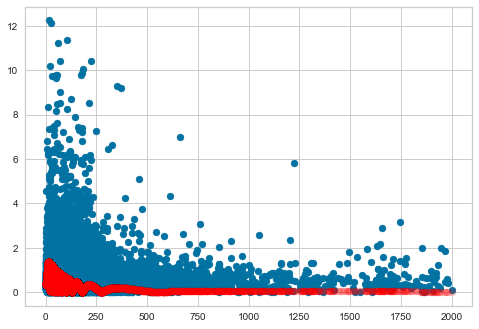

In [15]:
#função customizada de ajuste a modelo não linear
#leva em conta: potência de transmissão, ganho da antena, altura da antena, altura do receptor e frequência de operação
def func(x, w, g, ht, hr, frequency):
    factor = (30 * w * 10 ** (g / 10)) ** (0.5)
    dd = ((x ** 2) + (ht - hr) ** 2) ** 0.5
    dr = ((x ** 2) + (ht + hr) ** 2) ** 0.5
    lmbda = 299792458 / frequency
    beta = 2 * np.pi / lmbda
    real_part = (1 / dd) * np.cos(beta * dd) - (1 / dr) * np.cos(beta * dr)
    imaginary_part = -(1 / dd) * np.sin(beta * dd) + (1 / dr) * np.sin(beta * dr)
    
    result_module = factor * ( (real_part ** 2) + (imaginary_part ** 2) ) ** 0.5
    return result_module

#dataframe filtrado apenas com medições feitas em distâncias menores do que 2000m
fdf = mdf.loc[mdf['Distancia'] <= 2000,['Distancia','Valor Medio']]

#separação em dados de treino e teste
X = fdf['Distancia']
y = fdf['Valor Medio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

min_tx_pwr = 5
max_tx_pwr = 50
min_gain_db = 1
max_gain_db = 10
min_h_tx = 10
max_h_tx = 60
min_h_rx = 1
max_h_rx = 10
min_freq = 800000000
max_freq = 1800000000

#ajuste à função não linear
popt, _ = curve_fit(func, X, y, p0 = [30,5,50,2,801000000], bounds = ([min_tx_pwr,min_gain_db,min_h_tx,min_h_rx,min_freq],[max_tx_pwr,max_gain_db, max_h_tx,max_h_rx,max_freq]))
#melhores parâmetros encontrados
w, g, ht, hr, frequency = popt

#plotagem dos gráficos: Truth  e Predicted
plt.scatter(X_test , y_test)
plt.scatter(X_test,func(X_test, w, g, ht, hr, frequency), color = 'red', alpha = 0.2)

print(f'PARÂMETROS ESTIMADOS:\nPotência de transmissão: {round(w,3)}W\nGanho de transmissão: {round(g,3)}dB\nAltura da antena: {round(ht,3)}m\nAltura do receptor: {round(hr,3)}m\nFrequência de transmissão: {round(frequency / 1000000,3)}MHz')
print(f'MSE:{mean_squared_error(y_test,func(X_test,w, g, ht, hr, frequency)) ** 0.5}')

Tecnologias por antena

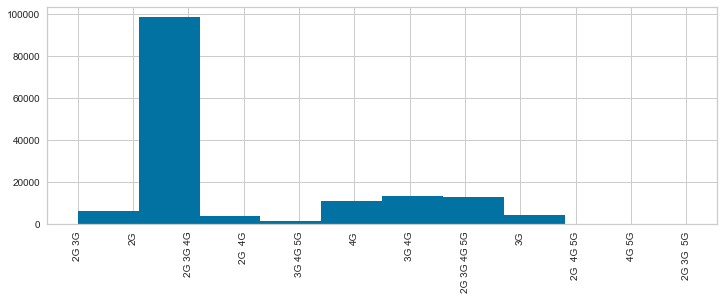

In [16]:
mdf['Tecs'].hist(figsize=(12,4))
plt.xticks(rotation='vertical');

Observe que os dados anteriores, são bastante condizentes com as informações encontradas na literatura científica:
    
Veja a potência transmitida (Ptx) para tecnologias 2G e 3G (~ 20W a 40W), conforme:
    
Oliver Arnold and Fred Richter and Gerhard P. Fettweis and Oliver Blume. Power consumption modeling of different base station types in heterogeneous cellular networks. 2010 Future Network & Mobile Summit. Pages 1 - 8. Disponível em: <https://www.semanticscholar.org/paper/Power-consumption-modeling-of-different-base-types-Arnold-Richter/da078d9f4c22c01e7acc4d85cc7bc929c61f3442/figure/2>.

<img src='ptx_2g_3g.png' width='500'>
    
<!-- Ainda, veja-se a potência transmitida (Ptx) para as tecnologias 2G e 3G, bem como as frequências de operação (~ ) Corrobora, ainda, com a tabela 1 do seguinte artigo:
    
Lorincz, Josip & Garma, Tonko. (2012). Measurements and Modelling of Base Station Power Consumption under Real Traffic Loads †. Sensors (Basel, Switzerland). Disponível em:<https://www.researchgate.net/publication/225186916_Measurements_and_Modelling_of_Base_Station_Power_Consumption_under_Real_Traffic_Loads/link/00b495151862b0b137000000/download>

<img src='ptx_2g_3g_nr2.png' width='500'> -->

Correlação entre variáveis

Observe a seguir que as variáveis de Latitude e Longitude dos locais das medições e das localizações das ERBs estão altamente correlacionadas. A explicação para isso se deve ao fato de que as medições foram efetuadas nas imediações das antenas, ou seja, em posições geográficas relativamente próximas e, portanto, bem correlacionadas.
    
Constata-se também que as variáveis Valor Médio (do campo eletromagnético) e % do Limite (do campo eletromagnético) também apresentam forte correlação. Ainda, quando calculada a correlação de Spearman, verifica-se que existe alguma correlação não-linear ainda mais acentuada entre o Valor Médio e o % do Limite. Essa correlação (Spearman) não exige que a relação entre as variáveis seja linear. Em outras palavras, o coeficiente avalia com que intensidade a relação entre duas variáveis pode ser descrita pelo uso de uma função monótona.

In [17]:
mdf_anapolis.corr('pearson')

,Latitude,Longitude,Valor Medio,% do Limite,ErbLat,ErbLong,Distancia
Latitude,1.000000,0.130774,0.068504,0.068266,0.995687,0.125528,0.110014
Longitude,0.130774,1.000000,-0.137089,-0.090238,0.132782,0.998769,0.145600
Valor Medio,0.068504,-0.137089,1.000000,0.903206,0.066916,-0.135012,0.012884
% do Limite,0.068266,-0.090238,0.903206,1.000000,0.069284,-0.087929,-0.007714
ErbLat,0.995687,0.132782,0.066916,0.069284,1.000000,0.128548,0.025884
ErbLong,0.125528,0.998769,-0.135012,-0.087929,0.128548,1.000000,0.127572
Distancia,0.110014,0.145600,0.012884,-0.007714,0.025884,0.127572,1.000000


In [18]:
mdf_anapolis.corr('spearman')

,Latitude,Longitude,Valor Medio,% do Limite,ErbLat,ErbLong,Distancia
Latitude,1.000000,0.102088,0.031323,0.032610,0.994665,0.097032,0.008759
Longitude,0.102088,1.000000,-0.109388,-0.108421,0.094534,0.997995,0.088757
Valor Medio,0.031323,-0.109388,1.000000,0.991632,0.020315,-0.109670,0.131459
% do Limite,0.032610,-0.108421,0.991632,1.000000,0.021215,-0.108915,0.138754
ErbLat,0.994665,0.094534,0.020315,0.021215,1.000000,0.089134,-0.025155
ErbLong,0.097032,0.997995,-0.109670,-0.108915,0.089134,1.000000,0.091601
Distancia,0.008759,0.088757,0.131459,0.138754,-0.025155,0.091601,1.000000


Observe a seguir que  as features Valor Médio e % do Limite estão fortemente correlacionadas. Ainda, apresentam uma correspondência semelhante a uma relação quadrática.

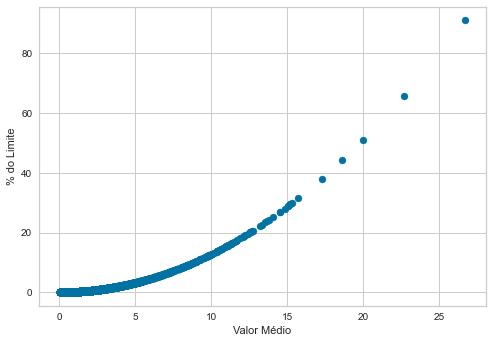

In [19]:
plt.scatter(mdf['Valor Medio'], mdf['% do Limite'])
plt.xlabel('Valor Médio')
plt.ylabel('% do Limite');

### Modelo de ajuste não linear
A seguir, é realizada uma função de ajuste (a uma função quadrática) entre as variáveis anteriormente mencionadas ( Valor Médio e % do Limite). Os resultados apresentados pelo ajuste revelam que essencialmente a relação entre as variáveis se dá por: 
    
% do Limite = 0.1275 * Valor Médio²
    
A correlação obtida é de 99,99%

Valor dos parâmetros de ajuste:
a:0.1275	b:0.0004	c:-0.0003

MSE: 0.002881337575694838


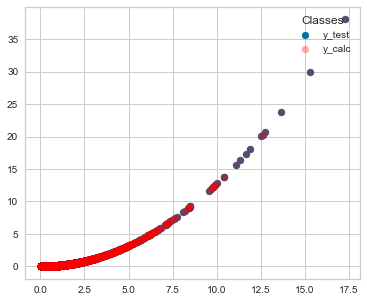

In [20]:
#função de ajuste a modelo não linear
def func(x, a, b, c):
    return a * (x**2) + b * x + c

X = mdf.drop(['% do Limite'], axis = 1)
y = mdf['% do Limite']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

popt, _ = curve_fit(func, X_train['Valor Medio'], y_train)
a, b, c = popt

print(f'Valor dos parâmetros de ajuste:\na:{round(a,4)}\tb:{round(b,4)}\tc:{round(c,4)}')

#plotagem dos gráficos: Truth e Predicted entre Valor Médio e % do Limite
fig, axs = plt.subplots(1,1,figsize=(6,5))
axs.scatter(X_test['Valor Medio'] , y_test, alpha = 1)
axs.scatter(X_test['Valor Medio'],func(X_test['Valor Medio'], a, b, c), color = 'red', alpha = 0.3)
legend1 = axs.legend(['y_test', 'y_calc'], loc="upper right", title="Classes")

#valores calculados pela função de ajuste não linear
y_calc = a * (X_test['Valor Medio'] ** 2)

print(f'\nMSE: {(mean_squared_error(y_test, y_calc)) ** 0.5}')

### Algoritmos supervisionados - Variáveis Valor Médio e % do Limite

Modelos e hiperparâmetros a serem utilizados

In [21]:
# modelos = []
# modelos.append(('LR', LinearRegression(),{}))
# modelos.append(('SGD', Pipeline(steps=[('scaler',StandardScaler()),('sgd',SGDRegressor(max_iter=1000, tol=1e-3))]),{
#     'sgd__alpha':[0.001],
#     'sgd__penalty':['l1'],
#     'sgd__l1_ratio':[0.15]
# }))
# modelos.append(('RDG', Ridge(),{
#     'alpha': [0.1,1]
# }))
# modelos.append(('LSS', Lasso(),{
#     'alpha': [0.1,1]
# }))
# modelos.append(('ELN', ElasticNet(),{
#     'alpha': [0.1,0.9], 
#     'l1_ratio':[0.1,0.9]
# }))
# modelos.append(('KNR', KNeighborsRegressor(),{
#     'n_neighbors': [5,8],
#     'weights':['uniform','distance'],
#     'algorithm':['auto','brute']
# }))
# #modelos.append(('SVR', SVR(),{
# #    'kernel':['rbf','poly'],
# #    'degree':[2],
# #    'epsilon':[0.05],
# #    'C':[0.9]
# #}))
# modelos.append(('ABR', AdaBoostRegressor(),{
#     'learning_rate':[0.0015]
# }))
# modelos.append(('DTR', DecisionTreeRegressor(),{
#     'criterion':['squared_error'],
#     'min_samples_split':[4,5],
#     'min_samples_leaf':[18,25],
#     'max_depth':[2,6]
# }))
# modelos.append(('RF', RandomForestRegressor(),{
#     'criterion':['squared_error','friedman_mse','poisson'],
#     'min_samples_split':[4,5],
#     'min_samples_leaf':[6,25],
#     'max_depth':[2,8]
# }))

modelos = []
modelos.append(('LR', LinearRegression(),{}))
modelos.append(('SGD', Pipeline(steps=[('scaler',StandardScaler()),('sgd',SGDRegressor(max_iter=1000, tol=1e-3))]),{
    'sgd__alpha':[0.001],
    'sgd__penalty':['l1'],
    'sgd__l1_ratio':[0.15]
}))
modelos.append(('RDG', Ridge(),{
    'alpha': [1]
}))
modelos.append(('LSS', Lasso(),{
    'alpha': [0.01]
}))
modelos.append(('ELN', ElasticNet(),{
    'alpha': [0.003], 
    'l1_ratio':[0.001]
}))
modelos.append(('KNR', KNeighborsRegressor(),{
    #'n_neighbors': [40],
    'n_neighbors': [5,8],
    'weights':['uniform','distance'],
    'algorithm':['auto','brute']
}))
#modelos.append(('SVR', SVR(),{
#    'kernel':['rbf','poly'],
#    'degree':[2],
#    'epsilon':[0.05],
#    'C':[0.9]
#}))
modelos.append(('ABR', AdaBoostRegressor(),{
    'learning_rate': [0.0017]
}))
modelos.append(('DTR', DecisionTreeRegressor(),{
    'criterion':['squared_error'],
    'min_samples_split':[2],
    'min_samples_leaf':[25],
    'max_depth':[6]
}))
modelos.append(('RF', RandomForestRegressor(),{
    'criterion':['squared_error','friedman_mse','poisson'],
    'min_samples_split':[2],
    'min_samples_leaf':[2],
    'max_depth':[2]
}))

In [22]:
#função que analiza todos os modelos anteriores, com seus hiperparâmetros e seus desempenhos correspondentes
def analyze_models(X,y):
    models_performance = {}
    models_best_params = {}
    for modelo in modelos:
        nome = modelo[0]
        modelo_aplicado = modelo[1]
        param_grid = modelo[2]
        
        print(f'Modelo em construção: {nome}')

        #verifica se foram setados hiperparâmtros customizados para determinado modelo
        if param_grid == {}:
            custom_params = 0
            param_grid = {k: [v] for k, v in modelo_aplicado.get_params().items()}
        else:
            custom_params = 1

        scoring = 'neg_mean_squared_error'
        
        #aplicação de GridSearchCV para verificação dos hiperparâmetros explicitados em cada modelo
        kfold = KFold(n_splits=5, shuffle = True)
        grid = GridSearchCV(modelo_aplicado, param_grid = param_grid, cv=kfold, scoring=scoring)
        grid.fit(X,y)
        models_performance[nome] = -grid.best_score_
        if custom_params == 1:
            models_best_params[nome] = grid.best_params_

    #performance de cada modelo com seus respectivos hiperparâmetros ótimos
    sorted_performance = {k: v for k, v in sorted(models_performance.items(), key=lambda item: item[1], reverse = False)}

    return sorted_performance, models_best_params

In [23]:
analyze_models(mdf_anapolis[['Valor Medio']],mdf_anapolis['% do Limite'])

Modelo em construção: LR
Modelo em construção: SGD
Modelo em construção: RDG
Modelo em construção: LSS
Modelo em construção: ELN
Modelo em construção: KNR
Modelo em construção: ABR
Modelo em construção: DTR
Modelo em construção: RF


({'ABR': 0.0022064810669948916,
  'KNR': 0.002395106787675582,
  'RF': 0.017859586887045475,
  'RDG': 0.020153927955891614,
  'LR': 0.020332197992704155,
  'LSS': 0.021264048673839717,
  'ELN': 0.021499533842795758,
  'SGD': 0.03029892650839756,
  'DTR': 0.07556356222016006},
 {'SGD': {'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.15, 'sgd__penalty': 'l1'},
  'RDG': {'alpha': 1},
  'LSS': {'alpha': 0.01},
  'ELN': {'alpha': 0.003, 'l1_ratio': 0.001},
  'KNR': {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'},
  'ABR': {'learning_rate': 0.0017},
  'DTR': {'criterion': 'squared_error',
   'max_depth': 6,
   'min_samples_leaf': 25,
   'min_samples_split': 2},
  'RF': {'criterion': 'friedman_mse',
   'max_depth': 2,
   'min_samples_leaf': 2,
   'min_samples_split': 2}})

### Algoritmos supervisionados - Variáveis Distância e Valor Médio

In [24]:
models_performance, models_best_params = analyze_models(mdf_anapolis[['Distancia']],mdf_anapolis['Valor Medio'])
print(models_best_params)
models_performance

Modelo em construção: LR
Modelo em construção: SGD
Modelo em construção: RDG
Modelo em construção: LSS
Modelo em construção: ELN
Modelo em construção: KNR
Modelo em construção: ABR
Modelo em construção: DTR
Modelo em construção: RF
{'SGD': {'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.15, 'sgd__penalty': 'l1'}, 'RDG': {'alpha': 1}, 'LSS': {'alpha': 0.01}, 'ELN': {'alpha': 0.003, 'l1_ratio': 0.001}, 'KNR': {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'uniform'}, 'ABR': {'learning_rate': 0.0017}, 'DTR': {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 2}, 'RF': {'criterion': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}}


{'RDG': 0.31634269190835773,
 'LR': 0.31706254476921886,
 'LSS': 0.31888701024499755,
 'ELN': 0.3191219171955241,
 'RF': 0.31921069455691264,
 'SGD': 0.32004018672918666,
 'DTR': 0.3310896884699616,
 'KNR': 0.34869124926736994,
 'ABR': 0.44363300211480217}

### Curva de Aprendizado (Learning Curve)

Os gráficos de curva de aprendizado abaixo refletem a realidade das medições para a cidade de Anápolis. Vamos analisá-los:
    
Para boa parte dos algoritmos (LR, SGD, RDG, LSS, ELN, SVR, DTR e RF) observa-se que em boa parte do processo de curva de aprendizado, o custo de validação é inferior ao custo de treinamento, presumindo que  o conjunto de validação aparenta ser de mais fácil predição do que o conjunto de treinamento, o que pode caracterizar um conjunto de treinamento não representativo. Em outras palavras é possível afirmar que o conjunto de treinamento não fornece informações suficientes para a generalização adequada dos modelos, ou então que os dados de treinamento não sejam adequados e representativos para a generalização dos modelos.
    
Pode-se interpretar também, ainda referente aos gráficos anteriores, que o custo de treinamento se reduz continuamente enquanto o custo de validação pouco ou em quase nada se altera, ou seja, os modelos estão se adequando mais aos dados de treinamento (custo se reduz), mas sendo incapazes de generalizar seus resultados para o conjunto de validação (custo praticamente inalterado), corroborando a idéia de uma possível não representatividade dos dados.
    
Para o algoritmo KNR, parece haver um overfitting, visto que o custo de treinamento se reduz e o custo de validação tende a apresentar uma leve piora.

O algoritmo ABR reflete algum decréscimo dos custos de treinamento e de validação, mas evidencia uma tendência de equilíbrio para o conjunto de validação, enquanto o conjunto de treinamento parece ainda ter tendência a se reduzir, sugerindo um possível overfitting a partir desse momento.

Com relação a uma possível hipótese de underfitting, esta não se verifica: em nenhum dos gráficos se evidencia algum possível esboço de tendência melhora dos modelos com características de que fossem abruptamente interrompidos, sugerindo que mais dados de treinamento ou mais épocas pudessem ser fatores de aprimoramento para eles.

Em todos os modelos se observa um problema de baixa variância, visto que há pouca diferença entre os "valores de equilíbrio" para treinamento e para teste (exceto para o modelo KNR, em que as curvas apresentam elevada tendência de distanciamento: melhora para treino e piora para validação). 

Ainda, pode-se afirmar que há um problema geral de bias elevado, visto que todas as curvas tendem a estabelecer uma espécie de tendência de equilíbrio em um valor distante de ser o ideal. Em outras palavras, as curvas apresentam certa perenidade para um elevado valor de MSE, o que não é adequado.

In [25]:
def plot_learning_curves(X,y):
    fig, axs = plt.subplots(4, 3, figsize=(20, 20))
    scoring = 'neg_mean_squared_error'
    for i, model in enumerate(modelos):
        name = model[0]
        modelo_aplicado = model[1]

        if name in models_best_params:
            modelo_aplicado = modelo_aplicado.set_params(**models_best_params[name])

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=modelo_aplicado, 
            X=X,
            y=y, 
            cv=5, 
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 20),
            n_jobs=1)

        train_mean = -np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = -np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        axs[i//3, i%3].plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
        axs[i//3, i%3].fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
        axs[i//3, i%3].plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
        axs[i//3, i%3].fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

        axs[i//3, i%3].set_title(f'Learning Curve for {name}')
        axs[i//3, i%3].set_xlabel('Training Data Size')
        axs[i//3, i%3].set_ylabel(f'MSE')
        axs[i//3, i%3].grid()
        axs[i//3, i%3].legend(loc='lower right')

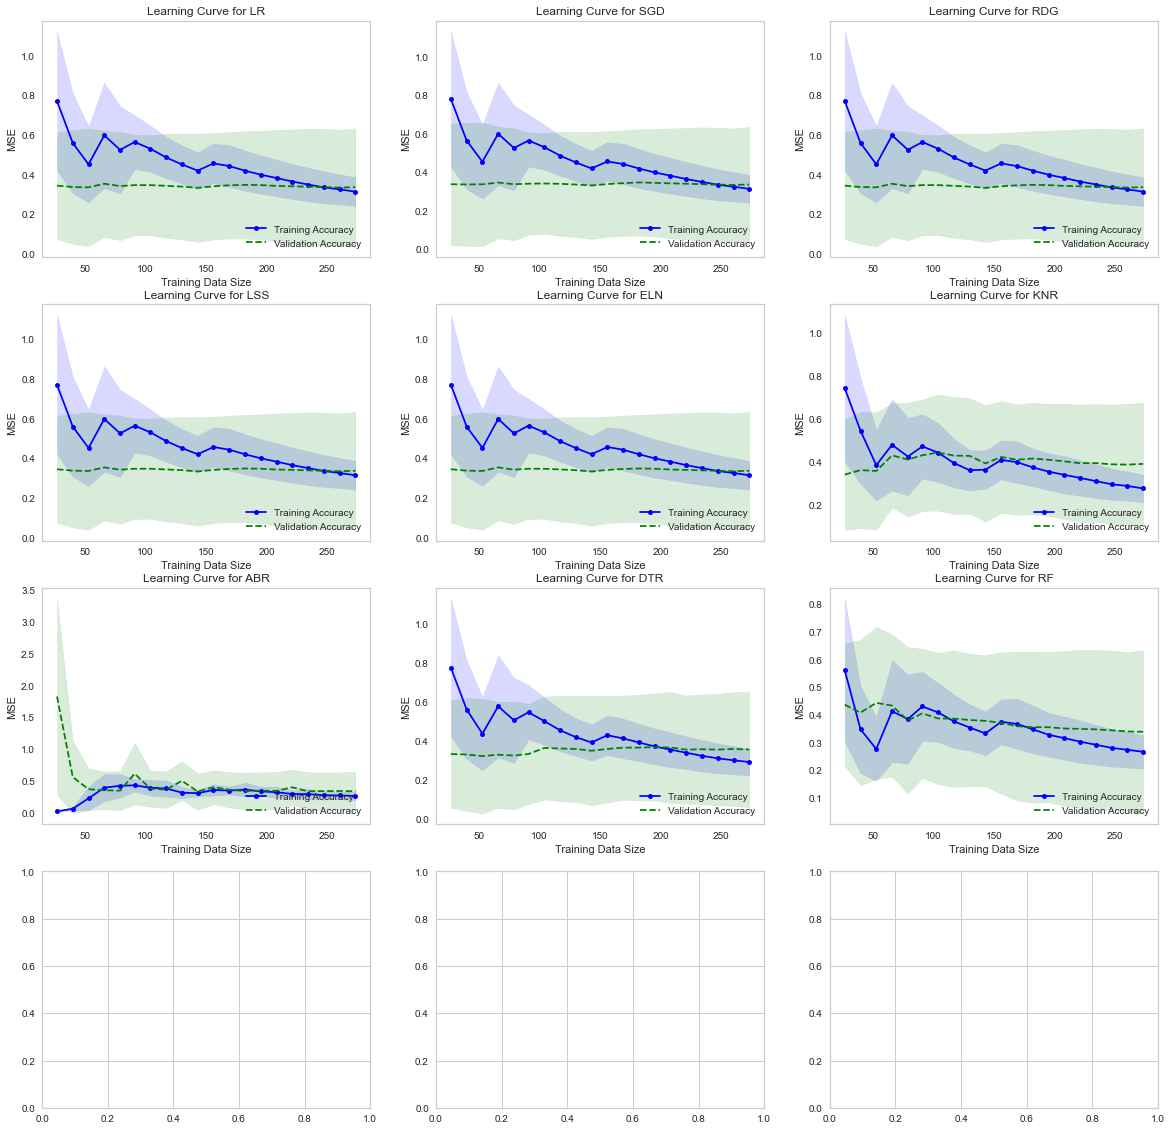

In [26]:
plot_learning_curves(mdf_anapolis[['Distancia']],mdf_anapolis['Valor Medio'])

Performance dos modelos para o dataset completo (requer elevado custo computacional, mas os gráficos são semelhantes)

In [27]:
# dfr = mdf.loc[mdf['Distancia'] < 2000]
# models_performance, models_best_params = analyze_models(dfr[['Distancia']],dfr['Valor Medio'])
# print(models_best_params)
# models_performance

In [28]:
# plot_learning_curves(dfr[['Distancia']], dfr['Valor Medio'])

### Testes de Feature Engineering

In [29]:
# f = mdf.loc[(mdf['Municipio'] == 'Anápolis') & (mdf['Distancia'] <= 2000)]
# f.head()
f = mdf.loc[(mdf['Municipio'] == 'Anápolis') & (mdf['Distancia'] <= 2000)]
f

,Nome Responsável,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora,ErbLat,ErbLong,Tecs,Time,Distancia
14223,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40559,-48.97821,Anápolis,GO,0.40,0.02,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,72.2
14224,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40433,-48.97911,Anápolis,GO,0.81,0.08,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,98.9
14225,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40371,-48.97754,Anápolis,GO,0.51,0.03,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,196.8
14226,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40711,-48.97761,Anápolis,GO,0.78,0.08,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,249.2
14241,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40689,-48.94219,Anápolis,GO,0.20,0.01,1002487800,TIM,-16.406944,-48.941944,4G,2016-01-05 15:30:00,26.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150634,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.27728,-48.78670,Anápolis,GO,0.29,0.01,403000793,Claro,-16.279719,-48.800961,2G 3G 4G,2016-02-21 00:45:00,1546.2
150928,My Business,Faixa Larga,-16.35033,-48.93733,Anápolis,GO,0.60,0.05,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,131.3
150929,My Business,Faixa Larga,-16.35011,-48.93864,Anápolis,GO,0.93,0.11,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,95.5
150930,My Business,Faixa Larga,-16.34928,-48.93842,Anápolis,GO,0.56,0.04,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,36.3


#### Feature Engineering:

criação das colunas Power, Gain, Tx_Height, Rx_Height e Frequency

In [30]:
import warnings
warnings.filterwarnings("ignore")

#função customizada de ajuste a modelo não linear
#leva em conta: potência de transmissão, ganho da antena, altura da antena, altura do receptor e frequência de operação
def func(x, w, g, ht, hr, frequency):
    factor = (30 * w * 10 ** (g / 10)) ** (0.5)
    dd = ((x ** 2) + (ht - hr) ** 2) ** 0.5
    dr = ((x ** 2) + (ht + hr) ** 2) ** 0.5
    lmbda = 299792458 / frequency
    beta = 2 * np.pi / lmbda
    real_part = (1 / dd) * np.cos(beta * dd) - (1 / dr) * np.cos(beta * dr)
    imaginary_part = -(1 / dd) * np.sin(beta * dd) + (1 / dr) * np.sin(beta * dr)
    
    result_module = factor * ( (real_part ** 2) + (imaginary_part ** 2) ) ** 0.5
    return result_module

#predições dos valores de cada coluna para cada estação
station_predictions = {}
for i,station in enumerate(f['Número Estação'].unique()):
        fdf = f.loc[(f['Número Estação'] == station),['Distancia','Valor Medio']]

        #separação em dados de treino e teste
        X = fdf['Distancia']
        y = fdf['Valor Medio']
        
        min_tx_pwr = 5
        max_tx_pwr = 50
        min_gain_db = 1
        max_gain_db = 10
        min_h_tx = 10
        max_h_tx = 60
        min_h_rx = 1
        max_h_rx = 10
        min_freq = 800000000
        max_freq = 1800000000

        try:
            popt, _ = curve_fit(func, X, y, p0 = [30,5,50,2,801000000], bounds = ([min_tx_pwr,min_gain_db,min_h_tx,min_h_rx,min_freq],[max_tx_pwr,max_gain_db, max_h_tx,max_h_rx,max_freq]))
            w, g, ht, hr, frequency = popt
        except:
            w, g, ht, hr, frequency = np.nan,np.nan,np.nan,np.nan,np.nan
        #melhores parâmetros encontrados
        #w, g, ht, hr, frequency = popt
        
        station_predictions[station] = {'w':w, 'g':g, 'ht':ht, 'hr':hr, 'f':frequency}

#criação das colunas mencionadas
f['Power'] = f['Número Estação'].apply(lambda x: round(station_predictions[x]['w'],1))
f['Gain'] = f['Número Estação'].apply(lambda x: round(station_predictions[x]['g'],2))
f['Tx_Height'] = f['Número Estação'].apply(lambda x: round(station_predictions[x]['ht'],1))
f['Rx_Height'] = f['Número Estação'].apply(lambda x: round(station_predictions[x]['hr'],1))
f['Frequency'] = f['Número Estação'].apply(lambda x: int(station_predictions[x]['f'] / 1000000))

f.dropna(inplace=True)

f

,Nome Responsável,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora,ErbLat,ErbLong,Tecs,Time,Distancia,Power,Gain,Tx_Height,Rx_Height,Frequency
14223,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40559,-48.97821,Anápolis,GO,0.40,0.02,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,72.2,30.0,5.00,50.0,2.0,800
14224,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40433,-48.97911,Anápolis,GO,0.81,0.08,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,98.9,30.0,5.00,50.0,2.0,800
14225,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40371,-48.97754,Anápolis,GO,0.51,0.03,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,196.8,30.0,5.00,50.0,2.0,800
14226,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40711,-48.97761,Anápolis,GO,0.78,0.08,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,249.2,30.0,5.00,50.0,2.0,800
14241,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40689,-48.94219,Anápolis,GO,0.20,0.01,1002487800,TIM,-16.406944,-48.941944,4G,2016-01-05 15:30:00,26.9,30.0,4.98,50.0,1.8,800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150634,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.27728,-48.78670,Anápolis,GO,0.29,0.01,403000793,Claro,-16.279719,-48.800961,2G 3G 4G,2016-02-21 00:45:00,1546.2,30.0,5.00,50.0,2.0,801
150928,My Business,Faixa Larga,-16.35033,-48.93733,Anápolis,GO,0.60,0.05,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,131.3,30.0,5.00,50.0,2.0,801
150929,My Business,Faixa Larga,-16.35011,-48.93864,Anápolis,GO,0.93,0.11,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,95.5,30.0,5.00,50.0,2.0,801
150930,My Business,Faixa Larga,-16.34928,-48.93842,Anápolis,GO,0.56,0.04,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,36.3,30.0,5.00,50.0,2.0,801


In [31]:
analyze_models(f[['Distancia','Power','Gain','Tx_Height','Rx_Height', 'Frequency']],f['Valor Medio'])

Modelo em construção: LR
Modelo em construção: SGD
Modelo em construção: RDG
Modelo em construção: LSS
Modelo em construção: ELN
Modelo em construção: KNR
Modelo em construção: ABR
Modelo em construção: DTR
Modelo em construção: RF


({'ELN': 0.30719273580800055,
  'RDG': 0.30960567328233657,
  'SGD': 0.3122470469931817,
  'LR': 0.3124227457168144,
  'RF': 0.3179692812691048,
  'ABR': 0.3181990546152435,
  'LSS': 0.31942901574836213,
  'DTR': 0.3340439645105017,
  'KNR': 0.362684289535777},
 {'SGD': {'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.15, 'sgd__penalty': 'l1'},
  'RDG': {'alpha': 1},
  'LSS': {'alpha': 0.01},
  'ELN': {'alpha': 0.003, 'l1_ratio': 0.001},
  'KNR': {'algorithm': 'brute', 'n_neighbors': 8, 'weights': 'uniform'},
  'ABR': {'learning_rate': 0.0017},
  'DTR': {'criterion': 'squared_error',
   'max_depth': 6,
   'min_samples_leaf': 25,
   'min_samples_split': 2},
  'RF': {'criterion': 'poisson',
   'max_depth': 2,
   'min_samples_leaf': 2,
   'min_samples_split': 2}})

#### Filtragem de outliers das features criadas

In [32]:
# def boxplot_data(df,col):
#     data = {}
#     q3 = np.percentile(df[col],75)
#     q2 = np.percentile(df[col],50)
#     q1 = np.percentile(df[col],25)
#     mean = np.mean(df[col])
#     iiq = q3-q1
#     LS = q3 + 1.5 * iiq
#     LI = q1 - 1.5 * iiq
    
#     regular_values = []
#     outmin = []
#     outmax = []
#     for el in df[col]:
#         if( (el >= LI) & (el <= LS) ):
#             regular_values.append(el)
#         else:
#             if(el > LS):
#                 outmax.append(el)
#             if(el < LI):
#                 outmin.append(el)
            
#     dmax = max(regular_values)
#     dmin = min(regular_values)
    
#     data['outmax'] = outmax
#     data['max'] = dmax
#     data['q3'] = q3
#     data['q2'] = q2
#     data['q1'] = q1
#     data['mean'] = mean
#     data['min'] = dmin
#     data['outmin'] = outmin
    
    
# #     return data

In [33]:
#filtra os outliers
f2 = f[
    (f['Power'] >= 20) &
    
    (f['Tx_Height'] >= 15) &
    (f['Tx_Height'] < 65) &
    
    (f['Rx_Height'] <= 2) 
]

f2

,Nome Responsável,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora,ErbLat,ErbLong,Tecs,Time,Distancia,Power,Gain,Tx_Height,Rx_Height,Frequency
14223,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40559,-48.97821,Anápolis,GO,0.40,0.02,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,72.2,30.0,5.00,50.0,2.0,800
14224,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40433,-48.97911,Anápolis,GO,0.81,0.08,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,98.9,30.0,5.00,50.0,2.0,800
14225,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40371,-48.97754,Anápolis,GO,0.51,0.03,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,196.8,30.0,5.00,50.0,2.0,800
14226,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40711,-48.97761,Anápolis,GO,0.78,0.08,1002483465,TIM,-16.405111,-48.978667,4G,2016-01-05 15:15:00,249.2,30.0,5.00,50.0,2.0,800
14241,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.40689,-48.94219,Anápolis,GO,0.20,0.01,1002487800,TIM,-16.406944,-48.941944,4G,2016-01-05 15:30:00,26.9,30.0,4.98,50.0,1.8,800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150634,Associação Brasileira de Compatibilidade Eletr...,Faixa Larga,-16.27728,-48.78670,Anápolis,GO,0.29,0.01,403000793,Claro,-16.279719,-48.800961,2G 3G 4G,2016-02-21 00:45:00,1546.2,30.0,5.00,50.0,2.0,801
150928,My Business,Faixa Larga,-16.35033,-48.93733,Anápolis,GO,0.60,0.05,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,131.3,30.0,5.00,50.0,2.0,801
150929,My Business,Faixa Larga,-16.35011,-48.93864,Anápolis,GO,0.93,0.11,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,95.5,30.0,5.00,50.0,2.0,801
150930,My Business,Faixa Larga,-16.34928,-48.93842,Anápolis,GO,0.56,0.04,665608985,TIM,-16.349417,-48.938111,2G 3G 4G,2016-02-21 03:15:00,36.3,30.0,5.00,50.0,2.0,801


#### Desempenho dos modelos com outliers filtrados

In [34]:
analyze_models(f2[['Distancia','Power','Gain','Tx_Height','Rx_Height', 'Frequency']],f2['Valor Medio'])

Modelo em construção: LR
Modelo em construção: SGD
Modelo em construção: RDG
Modelo em construção: LSS
Modelo em construção: ELN
Modelo em construção: KNR
Modelo em construção: ABR
Modelo em construção: DTR
Modelo em construção: RF


({'ELN': 0.21492640152538525,
  'RDG': 0.21846572944359471,
  'LSS': 0.22064026905807257,
  'LR': 0.22656796094163853,
  'RF': 0.22842829471985265,
  'ABR': 0.2285544311527084,
  'DTR': 0.22941911839400642,
  'SGD': 0.22982325044252083,
  'KNR': 0.24419075958854286},
 {'SGD': {'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.15, 'sgd__penalty': 'l1'},
  'RDG': {'alpha': 1},
  'LSS': {'alpha': 0.01},
  'ELN': {'alpha': 0.003, 'l1_ratio': 0.001},
  'KNR': {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'},
  'ABR': {'learning_rate': 0.0017},
  'DTR': {'criterion': 'squared_error',
   'max_depth': 6,
   'min_samples_leaf': 25,
   'min_samples_split': 2},
  'RF': {'criterion': 'poisson',
   'max_depth': 2,
   'min_samples_leaf': 2,
   'min_samples_split': 2}})

30.0    184
29.9      8
21.7      4
39.1      4
47.4      4
21.1      4
26.3      4
24.9      4
29.8      4
Name: Power, dtype: int64

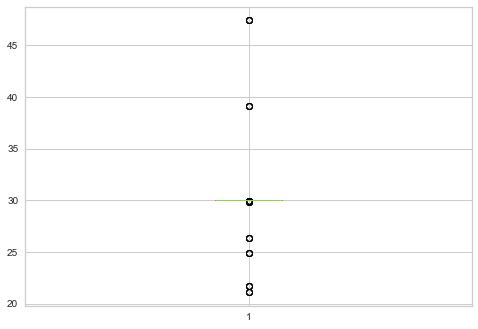

In [35]:
# feat = 'Power'
# plt.boxplot(f2[feat])
# f2[feat].value_counts()